# Fine-tuning Azure OpenAI GPT-4o for Chart Analysis

<img src="qna.png" width=800>

### Steps
- Collect and prepare the dataset.
- Configure and start the fine-tuning process.
- Deploy the fine-tuned model.
- Perform inference examples.
- Compare the performance of the baseline model with the fine-tuned model.

This project utilizes the ChartQA dataset introduced by Masry et al. in their paper, ChartQA: A Benchmark for Question Answering about Charts with Visual and Logical Reasoning (Findings of ACL 2022). We are grateful to the authors for providing this valuable resource.
[ChartQA: ACL 2022](https://aclanthology.org/2022.findings-acl.177).

### Dataset
https://huggingface.co/datasets/HuggingFaceM4/ChartQA

### Credits
https://github.com/Azure/gen-cv/blob/main/vision-fine-tuning/01-AOAI-vision-fine-tuning-starter/README.md

### Azure documentation for fine-tuning with Azure OpenAI
https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning

## 1 Setup

In [1]:
import base64
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import requests
import sys
import time

from azure.identity import DefaultAzureCredential
from datasets import load_dataset
from datetime import datetime
from dotenv import load_dotenv
from io import BytesIO, StringIO
from IPython.display import display, clear_output, FileLink
from openai import AzureOpenAI
from PIL import Image
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Azure OpenAI version: {openai.__version__}")

Azure OpenAI version: 1.59.6


In [4]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-20 08:00:19


In [13]:
project_name = "vqa-gpt4o"

train_samples = 1000  # You can increase these values to have more precision. First we will use few images to speed up the required time.
val_samples = 200
test_samples = 100

In [14]:
bold_start, bold_end = '\033[1m', '\033[0m'

SYSTEM_PROMPT = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [15]:
load_dotenv("azure.env")

api_key = os.getenv("api_key")
azure_endpoint = os.getenv("azure_endpoint")
subscription_id = os.getenv("subscription_id")
resource_name = os.getenv("resource_name")
rg_name = os.getenv("rg_name")

In [16]:
client = AzureOpenAI(api_key=api_key,
                     api_version="2024-10-21",
                     azure_endpoint=azure_endpoint)

## 2 Helper functions

In [17]:
def encode_image(image, quality=100):
    """
    Encodes an image to a base64 string after converting it to JPEG format.

    Parameters:
    image (PIL.Image.Image): The image to be encoded.
    quality (int, optional): The quality of the JPEG encoding (default is 100).

    Returns:
    str: The base64 encoded string of the JPEG image.
    """
    if image.mode != 'RGB':
        image = image.convert('RGB')
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality)

    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [18]:
def date_sorted_df(details_dict):
    """
    Converts a dictionary of details into a DataFrame, processes date columns, and sorts by creation date.

    Parameters:
    details_dict (dict): A dictionary containing the details to be converted into a DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with processed date columns and sorted by 'created_at' in descending order.
    """
    df = pd.DataFrame(details_dict)

    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)

    df['created_at'] = pd.to_datetime(
        df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        df['finished_at'] = pd.to_datetime(
            df['finished_at'], unit='s',
            errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

    df = df.sort_values(by='created_at', ascending=False)

    return df

In [19]:
def show_ft_metrics(results_df, window_size=5):
    """
    Plots training and validation metrics from a results DataFrame with optional smoothing.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing the training and validation metrics.
    window_size (int, optional): The window size for smoothing the metrics using a rolling mean
    (default is 5).

    Returns:
    None: This function displays the plots and does not return any value.
    """
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_loss'],
             color='blue')
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_mean_token_accuracy'],
             color='green')
    plt.title('Train Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_loss'],
             color='red')
    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_mean_token_accuracy'],
             color='orange')
    plt.title('Validation Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

## 3 Retrieve and prepare dataset

Fine-tuning for images is possible with JSONL dataset files similar to the process of sending images as input to the chat completion API.
Images can be provided as HTTP URLs (as shown below) or data URLs containing base64-encoded images.

```json
{
  "messages": [
    { "role": "system", "content": "You are an assistant that identifies corporate logos." },
    { "role": "user", "content": "What is this logo?" },
    { "role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/fr/thumb/b/b6/Microsoft-Azure.png/100px-Microsoft-Azure.png"
          }
        }
      ]
    },
    { "role": "assistant", "content": "Microsoft Azure" }
  ]
}
```
The following cell converts the ChartQA dataset from HuggingFace into this JSONL format by using base64-encoded images. Depending on your training data format, you will likely need to perform a few changes for reusing the code for your other use cases. 

> https://huggingface.co/datasets/HuggingFaceM4/ChartQA

In [20]:
ds = load_dataset("HuggingFaceM4/ChartQA")
display(ds)

# sample training, validation, and test examples
ds_train = ds['train'].shuffle(seed=42).select(range(train_samples))
ds_val = ds['val'].shuffle(seed=42).select(range(val_samples))
ds_test = ds['test'].shuffle(seed=42).select(range(test_samples))

# convert to pandas dataframe
ds_train = ds_train.to_pandas()
ds_val = ds_val.to_pandas()
ds_test = ds_test.to_pandas()

# convert byte strings to images
ds_train['image'] = ds_train['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))
ds_val['image'] = ds_val['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))
ds_test['image'] = ds_test['image'].apply(
    lambda x: Image.open(BytesIO(x['bytes'])))

# Convert array type of 'label' column into string only if the current data type is object
if ds_train['label'].dtype == 'object':
    ds_train['label'] = ds_train['label'].apply(lambda x: x[0])

if ds_val['label'].dtype == 'object':
    ds_val['label'] = ds_val['label'].apply(lambda x: x[0])

if ds_test['label'].dtype == 'object':
    ds_test['label'] = ds_test['label'].apply(lambda x: x[0])

ds_train = ds_train.rename(columns={'query': 'question', 'label': 'answer'})
ds_val = ds_val.rename(columns={'query': 'question', 'label': 'answer'})
ds_test = ds_test.rename(columns={'query': 'question', 'label': 'answer'})

ds_train = ds_train[['question', 'answer', 'image']]
ds_val = ds_val[['question', 'answer', 'image']]
ds_test = ds_test[['question', 'answer', 'image']]

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

In [21]:
ds_train

,question,answer,image
0,What is the sales performance of accessories b...,36,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,Is the cardiovascular disease more then sum of...,Yes,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What was the youth unemployment rate in Bosnia...,33.97,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What was MWG's net revenue in 2019?,102.17,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,What was the infant mortality rate in Uzbekist...,15.6,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
995,What was France's crude birth rate in 1800?,29.4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
996,How many colored segments are less than 10?,3,<PIL.PngImagePlugin.PngImageFile image mode=RG...
997,What was the fertility rate in Yemen in 2018?,3.79,<PIL.PngImagePlugin.PngImageFile image mode=RG...
998,What was the leading brewing company in Canada...,Molson Coors Brewing Company,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [22]:
ds_val

,question,answer,image
0,What was the value of the pizza delivery marke...,6.2,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the smallest value represented,9,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,Is Croatia global hunger index extremely alarm...,No,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What was Russia's fertility rate in 2020?,1.74,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,What is the ratio of fixed broadband in the ye...,1,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
195,How many respondents are not sure?,29,<PIL.PngImagePlugin.PngImageFile image mode=RG...
196,What's the percentage market share of NEXANS f...,27,<PIL.PngImagePlugin.PngImageFile image mode=RG...
197,"What's the percentage of men who have ""Should ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...
198,What is the difference of largest and smallest...,409.13,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [23]:
ds_test

,question,answer,image
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
95,Who has hit the most home runs in Kansas City ...,George Brett,<PIL.PngImagePlugin.PngImageFile image mode=RG...
96,What's the number of the highest point?,83.29,<PIL.PngImagePlugin.PngImageFile image mode=RG...
97,What was the value of the commercial property ...,883,<PIL.PngImagePlugin.PngImageFile image mode=RG...
98,"In the first quarter of 2021, what percentage ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...


### Displaying some elements from the dataset

QUESTION: Is the cardiovascular disease more then sum of all the other disease ?


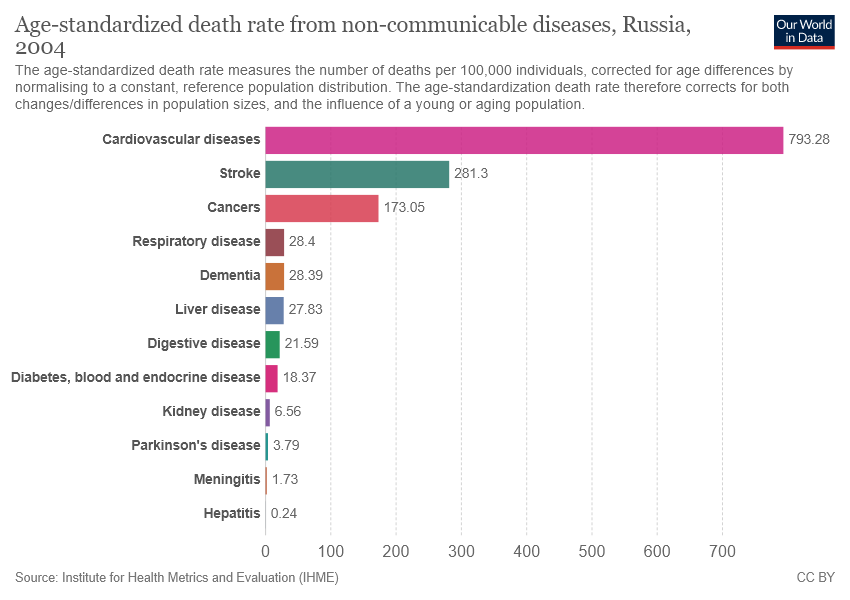

ANSWER: Yes


In [24]:
idx = 1

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: What was the unemployment rate in Massachusetts in 2020?


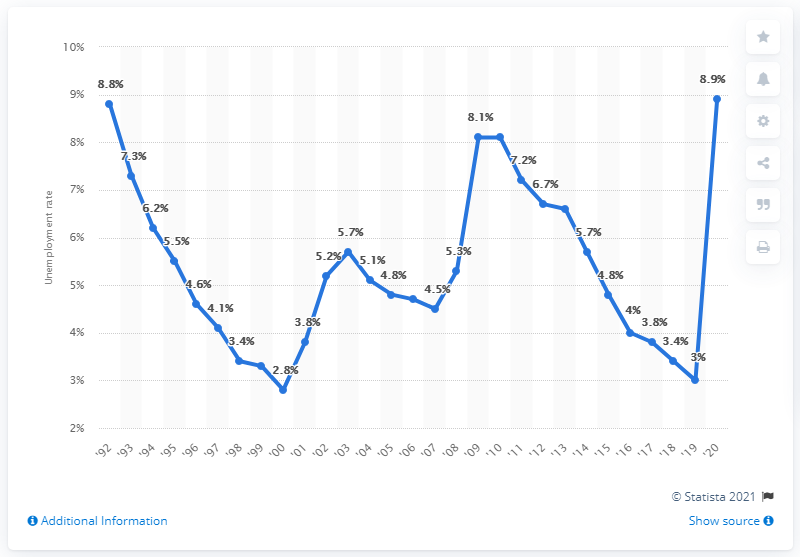

ANSWER: 8.9


In [25]:
idx = 10

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: What's the value of green bar in 2017?


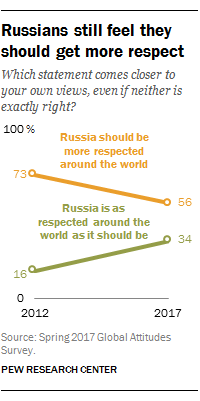

ANSWER: 34


In [26]:
idx = 50

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

### Partitioning the dataset

In [27]:
splits = ['train', 'val', 'test']
datasets = [ds_train, ds_val, ds_test]

for split, dataset in zip(splits, datasets):
    dataset_file = f"{project_name}-{split}.jsonl"
    print(f"Generating {dataset_file} with {dataset.shape[0]} samples.")

    json_data = []
    base64_prefix = "data:image/jpeg;base64,"

    for idx, example in tqdm(enumerate(dataset.itertuples()),
                             total=dataset.shape[0]):
        try:
            system_message = {"role": "system", "content": SYSTEM_PROMPT}

            encoded_image = encode_image(example.image, quality=80)
            user_message = {
                "role":
                "user",
                "content": [{
                    "type": "text",
                    "text": f"Question [{idx}]: {example.question}"
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{base64_prefix}{encoded_image}"
                    }
                }]
            }
            assistant_message = {
                "role": "assistant",
                "content": example.answer
            }

            json_data.append({
                "messages": [system_message, user_message, assistant_message]
            })
        except KeyError as e:
            print(f"Missing field in example {idx}: {e}")
        except Exception as e:
            print(f"Error processing example {idx}: {e}")

    with open(dataset_file, "w") as f:
        for message in json_data:
            json.dump(message, f)
            f.write("\n")

Generating vqa-gpt4o-train.jsonl with 1000 samples.


100%|██████████| 1000/1000 [00:11<00:00, 87.81it/s]


Generating vqa-gpt4o-val.jsonl with 200 samples.


100%|██████████| 200/200 [00:02<00:00, 88.50it/s]


Generating vqa-gpt4o-test.jsonl with 100 samples.


100%|██████████| 100/100 [00:01<00:00, 89.82it/s]


In [28]:
!ls *.jsonl -lh

-rwxrwxrwx 1 root root 5.6M Jan 20 08:03 vqa-gpt4o-test.jsonl
-rwxrwxrwx 1 root root  57M Jan 20 08:02 vqa-gpt4o-train.jsonl
-rwxrwxrwx 1 root root  11M Jan 20 08:03 vqa-gpt4o-val.jsonl


## 4 Configure and start fine-tuning job

In [29]:
# upload training file
train_file = client.files.create(file=open(f"{project_name}-train.jsonl",
                                           "rb"),
                                 purpose="fine-tune")

# upload validation file
val_file = client.files.create(file=open(f"{project_name}-val.jsonl", "rb"),
                               purpose="fine-tune")

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Batch size`                            | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256.                                                           |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs`       | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed`  | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

In [30]:
baseline_model = "gpt-4o-2024-08-06"  # Baseline model (not the deployment name model)

### Running the fine tuning job

In [31]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

ft_job = client.fine_tuning.jobs.create(
    suffix=project_name,
    training_file=file_train,
    validation_file=file_val,
    # baseline model name (not the deployment name)
    model=baseline_model,
    seed=None,
    hyperparameters={
        "n_epochs": None,
        "batch_size": None,
        "learning_rate_multiplier": None,
    })

In [32]:
display(ft_job.to_dict())

{'id': 'ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3',
 'created_at': 1737360204,
 'hyperparameters': {'batch_size': -1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': -1},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'seed': 971325359,
 'status': 'pending',
 'training_file': 'file-2fdc3057ff54489fb9b0c9518b34aa53',
 'validation_file': 'file-518d9c12b190445e988a1b257cd33379',
 'estimated_finish': 1737367737,
 'suffix': 'vqa-gpt4o'}

### List of fine tuned jobs

In [33]:
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()
date_sorted_df(pd.DataFrame(ft_jobs['data']))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,fine_tuned_model,finished_at,result_files,trained_tokens
0,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3,2025-01-20 08:03:24,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,971325359,pending,file-2fdc3057ff54489fb9b0c9518b34aa53,file-518d9c12b190445e988a1b257cd33379,1737367737,vqa-gpt4o,NaN,NaN,NaN,NaN
1,ftjob-c13effafe9e2421cb43f01426276c0ca,2025-01-17 16:39:12,"{'batch_size': 1, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1832573370,succeeded,file-f428fa1df2b843aba678363eaf7404e7,file-56085e73ebdc4876afc44d783fcd75ab,1737132876,defects_classification,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,2025-01-17 17:48:57,[file-6ced7bc7fd0642ce925622eda0e57076],271345.0
2,ftjob-9bf11339900f49cfbe65e23c779785ca,2025-01-13 08:01:39,"{'batch_size': 2, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1253563762,succeeded,file-7a1748e9eb964fc89db1f006b503b648,file-39f3487489fc4e7ea4c4d1bd2d5fdb93,1736762832,chart-qa-v4,gpt-4o-2024-08-06.ft-9bf11339900f49cfbe65e23c7...,2025-01-13 12:53:36,[file-9b44803fa1ef4d7e9063d4333d07aaeb],44224200.0


### Job status

In [37]:
job_id = date_sorted_df(pd.DataFrame(ft_jobs['data'])).at[0, "id"]
job_id

'ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3'

### job is pending

In [38]:
response = client.fine_tuning.jobs.retrieve(job_id)

print("Job ID:", response.id)
print("Status:", response.status)
print(response.model_dump_json(indent=2))

Job ID: ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
Status: pending
{
  "id": "ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3",
  "created_at": 1737360204,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 1.0,
    "n_epochs": -1
  },
  "model": "gpt-4o-2024-08-06",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": null,
  "seed": 971325359,
  "status": "pending",
  "trained_tokens": null,
  "training_file": "file-2fdc3057ff54489fb9b0c9518b34aa53",
  "validation_file": "file-518d9c12b190445e988a1b257cd33379",
  "estimated_finish": 1737367737,
  "integrations": null,
  "method": null,
  "suffix": "vqa-gpt4o"
}


In [40]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f'Job status of {job_id}: {client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]}')

2025-01-20 08:05:32
Job status of ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3: pending


### List of events

In [41]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
print(response.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "ftevent-7f7536442e8b4ee7a4df2663d5e54285",
      "created_at": 1737360209,
      "level": "info",
      "message": "Preprocessing running for file training file.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-0fa924efac5b4351a4b8551634c4e98f",
      "created_at": 1737360204,
      "level": "info",
      "message": "Job enqueued. Waiting for jobs ahead to complete.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    }
  ],
  "has_more": false,
  "object": "list"
}


### job is running

In [44]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(f'Job status of {job_id}: {client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]}')

2025-01-20 08:09:48
Job status of ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3: running


In [45]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
print(response.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "ftevent-f83b585aa3ff46398a296a7b5d82f7b9",
      "created_at": 1737360579,
      "level": "info",
      "message": "Preprocessing started.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-ef7e94d688d645fd9dbb67c6c8cfbbdd",
      "created_at": 1737360578,
      "level": "info",
      "message": "Job started.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-6db54d9fc6c847bb9a57f73035a734f6",
      "created_at": 1737360569,
      "level": "info",
      "message": "Preprocessing completed for file validation file.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-91c06ec2366046119965843cc27a3405",
      "created_at": 1737360568,
      "level": "info",
      "message": "Preprocessing completed for file training file.",
      "object": "fine_tuning

In [51]:
response = client.fine_tuning.jobs.retrieve(job_id)

print("Job ID:", response.id)
print("Status:", response.status)
print(response.model_dump_json(indent=2))

Job ID: ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
Status: running
{
  "id": "ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3",
  "created_at": 1737360204,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": 2,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 3
  },
  "model": "gpt-4o-2024-08-06",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": null,
  "seed": 971325359,
  "status": "running",
  "trained_tokens": null,
  "training_file": "file-2fdc3057ff54489fb9b0c9518b34aa53",
  "validation_file": "file-518d9c12b190445e988a1b257cd33379",
  "estimated_finish": 1737367737,
  "integrations": null,
  "method": null,
  "suffix": "vqa-gpt4o"
}


### Job status in Azure AI Foundry

<img src="capture1.jpg">

<img src="capture2.jpg" width=800>

In [106]:
print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Job status of {job_id}: {client.fine_tuning.jobs.list(limit=1).to_dict()['data'][0]['status']}")

2025-01-20 10:22:05 Job status of ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3: running


In [111]:
client.fine_tuning.jobs.list(limit=1).to_dict()

{'data': [{'id': 'ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3',
   'created_at': 1737360204,
   'hyperparameters': {'batch_size': 2,
    'learning_rate_multiplier': 1.0,
    'n_epochs': 3},
   'model': 'gpt-4o-2024-08-06',
   'object': 'fine_tuning.job',
   'result_files': ['file-b1b0c191277f444999a131bd437a6855'],
   'seed': 971325359,
   'status': 'running',
   'training_file': 'file-2fdc3057ff54489fb9b0c9518b34aa53',
   'validation_file': 'file-518d9c12b190445e988a1b257cd33379',
   'estimated_finish': 1737367737,
   'suffix': 'vqa-gpt4o'}],
 'has_more': True,
 'object': 'list'}

### Wait until completion

In [120]:
print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Job status of {job_id}: {client.fine_tuning.jobs.list(limit=1).to_dict()['data'][0]['status']}")

2025-01-20 10:36:38 Job status of ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3: running


In [128]:
while status not in ["succeeded", "failed"]:
    response = client.fine_tuning.jobs.retrieve(job_id)
    status = response.status
    print("\033[1;31;34m")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    response = client.fine_tuning.jobs.retrieve(job_id)
    print("\n", response.model_dump_json(indent=2))
    status = response.status
    print(f'\nStatus: {status}')
    clear_output(wait=True)  # Refresh current cell
    time.sleep(60)  # Wait 60 seconds

print(f"Fine-tuning job {job_id} finished with status: {status}")

Fine-tuning job ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3 finished with status: succeeded


In [130]:
client.fine_tuning.jobs.list(limit=1).to_dict()

{'data': [{'id': 'ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3',
   'created_at': 1737360204,
   'fine_tuned_model': 'gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f0fb80d3-vqa-gpt4o',
   'finished_at': 1737375631,
   'hyperparameters': {'batch_size': 2,
    'learning_rate_multiplier': 1.0,
    'n_epochs': 3},
   'model': 'gpt-4o-2024-08-06',
   'object': 'fine_tuning.job',
   'result_files': ['file-b1b0c191277f444999a131bd437a6855'],
   'seed': 971325359,
   'status': 'succeeded',
   'trained_tokens': 44224200,
   'training_file': 'file-2fdc3057ff54489fb9b0c9518b34aa53',
   'validation_file': 'file-518d9c12b190445e988a1b257cd33379',
   'estimated_finish': 1737367737,
   'suffix': 'vqa-gpt4o'}],
 'has_more': True,
 'object': 'list'}

In [131]:
response = client.fine_tuning.jobs.retrieve(job_id)
print(f"Job ID: {response.id}")
print(f"Status: {response.status}")
print(response.model_dump_json(indent=2))

Job ID: ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
Status: succeeded
{
  "id": "ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3",
  "created_at": 1737360204,
  "error": null,
  "fine_tuned_model": "gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f0fb80d3-vqa-gpt4o",
  "finished_at": 1737375631,
  "hyperparameters": {
    "batch_size": 2,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 3
  },
  "model": "gpt-4o-2024-08-06",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [
    "file-b1b0c191277f444999a131bd437a6855"
  ],
  "seed": 971325359,
  "status": "succeeded",
  "trained_tokens": 44224200,
  "training_file": "file-2fdc3057ff54489fb9b0c9518b34aa53",
  "validation_file": "file-518d9c12b190445e988a1b257cd33379",
  "estimated_finish": 1737367737,
  "integrations": null,
  "method": null,
  "suffix": "vqa-gpt4o"
}


In [132]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
print(response.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "ftevent-a61025a1a4194f1496b80c1a12f6fd0a",
      "created_at": 1737375631,
      "level": "info",
      "message": "Training tokens billed: 2702000",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-babc2a774f1f40adae3e2bbb5af85954",
      "created_at": 1737375631,
      "level": "info",
      "message": "Completed results file: file-b1b0c191277f444999a131bd437a6855",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-ca1e561f782b496db49e96331646c6ae",
      "created_at": 1737375630,
      "level": "info",
      "message": "Model Evaluation Passed.",
      "object": "fine_tuning.job.event",
      "data": null,
      "type": "message"
    },
    {
      "id": "ftevent-15b01d5aad97433186aeded652e57198",
      "created_at": 1737375622,
      "level": "info",
      "message": "Postprocessing started.",
      "object": "fi

<img src="capture3.jpg">

<img src="capture4.jpg">

### Fine tuning job metrics

In [133]:
print(f"Job status of {job_id}: {client.fine_tuning.jobs.list(limit=1).to_dict()['data'][0]['status']}")

Job status of ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3: succeeded


In [135]:
# Retrieve the state of a fine-tune job
ft_job = client.fine_tuning.jobs.retrieve(job_id)
ft_job.to_dict()

{'id': 'ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3',
 'created_at': 1737360204,
 'fine_tuned_model': 'gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f0fb80d3-vqa-gpt4o',
 'finished_at': 1737375631,
 'hyperparameters': {'batch_size': 2,
  'learning_rate_multiplier': 1.0,
  'n_epochs': 3},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'result_files': ['file-b1b0c191277f444999a131bd437a6855'],
 'seed': 971325359,
 'status': 'succeeded',
 'trained_tokens': 44224200,
 'training_file': 'file-2fdc3057ff54489fb9b0c9518b34aa53',
 'validation_file': 'file-518d9c12b190445e988a1b257cd33379',
 'estimated_finish': 1737367737,
 'suffix': 'vqa-gpt4o'}

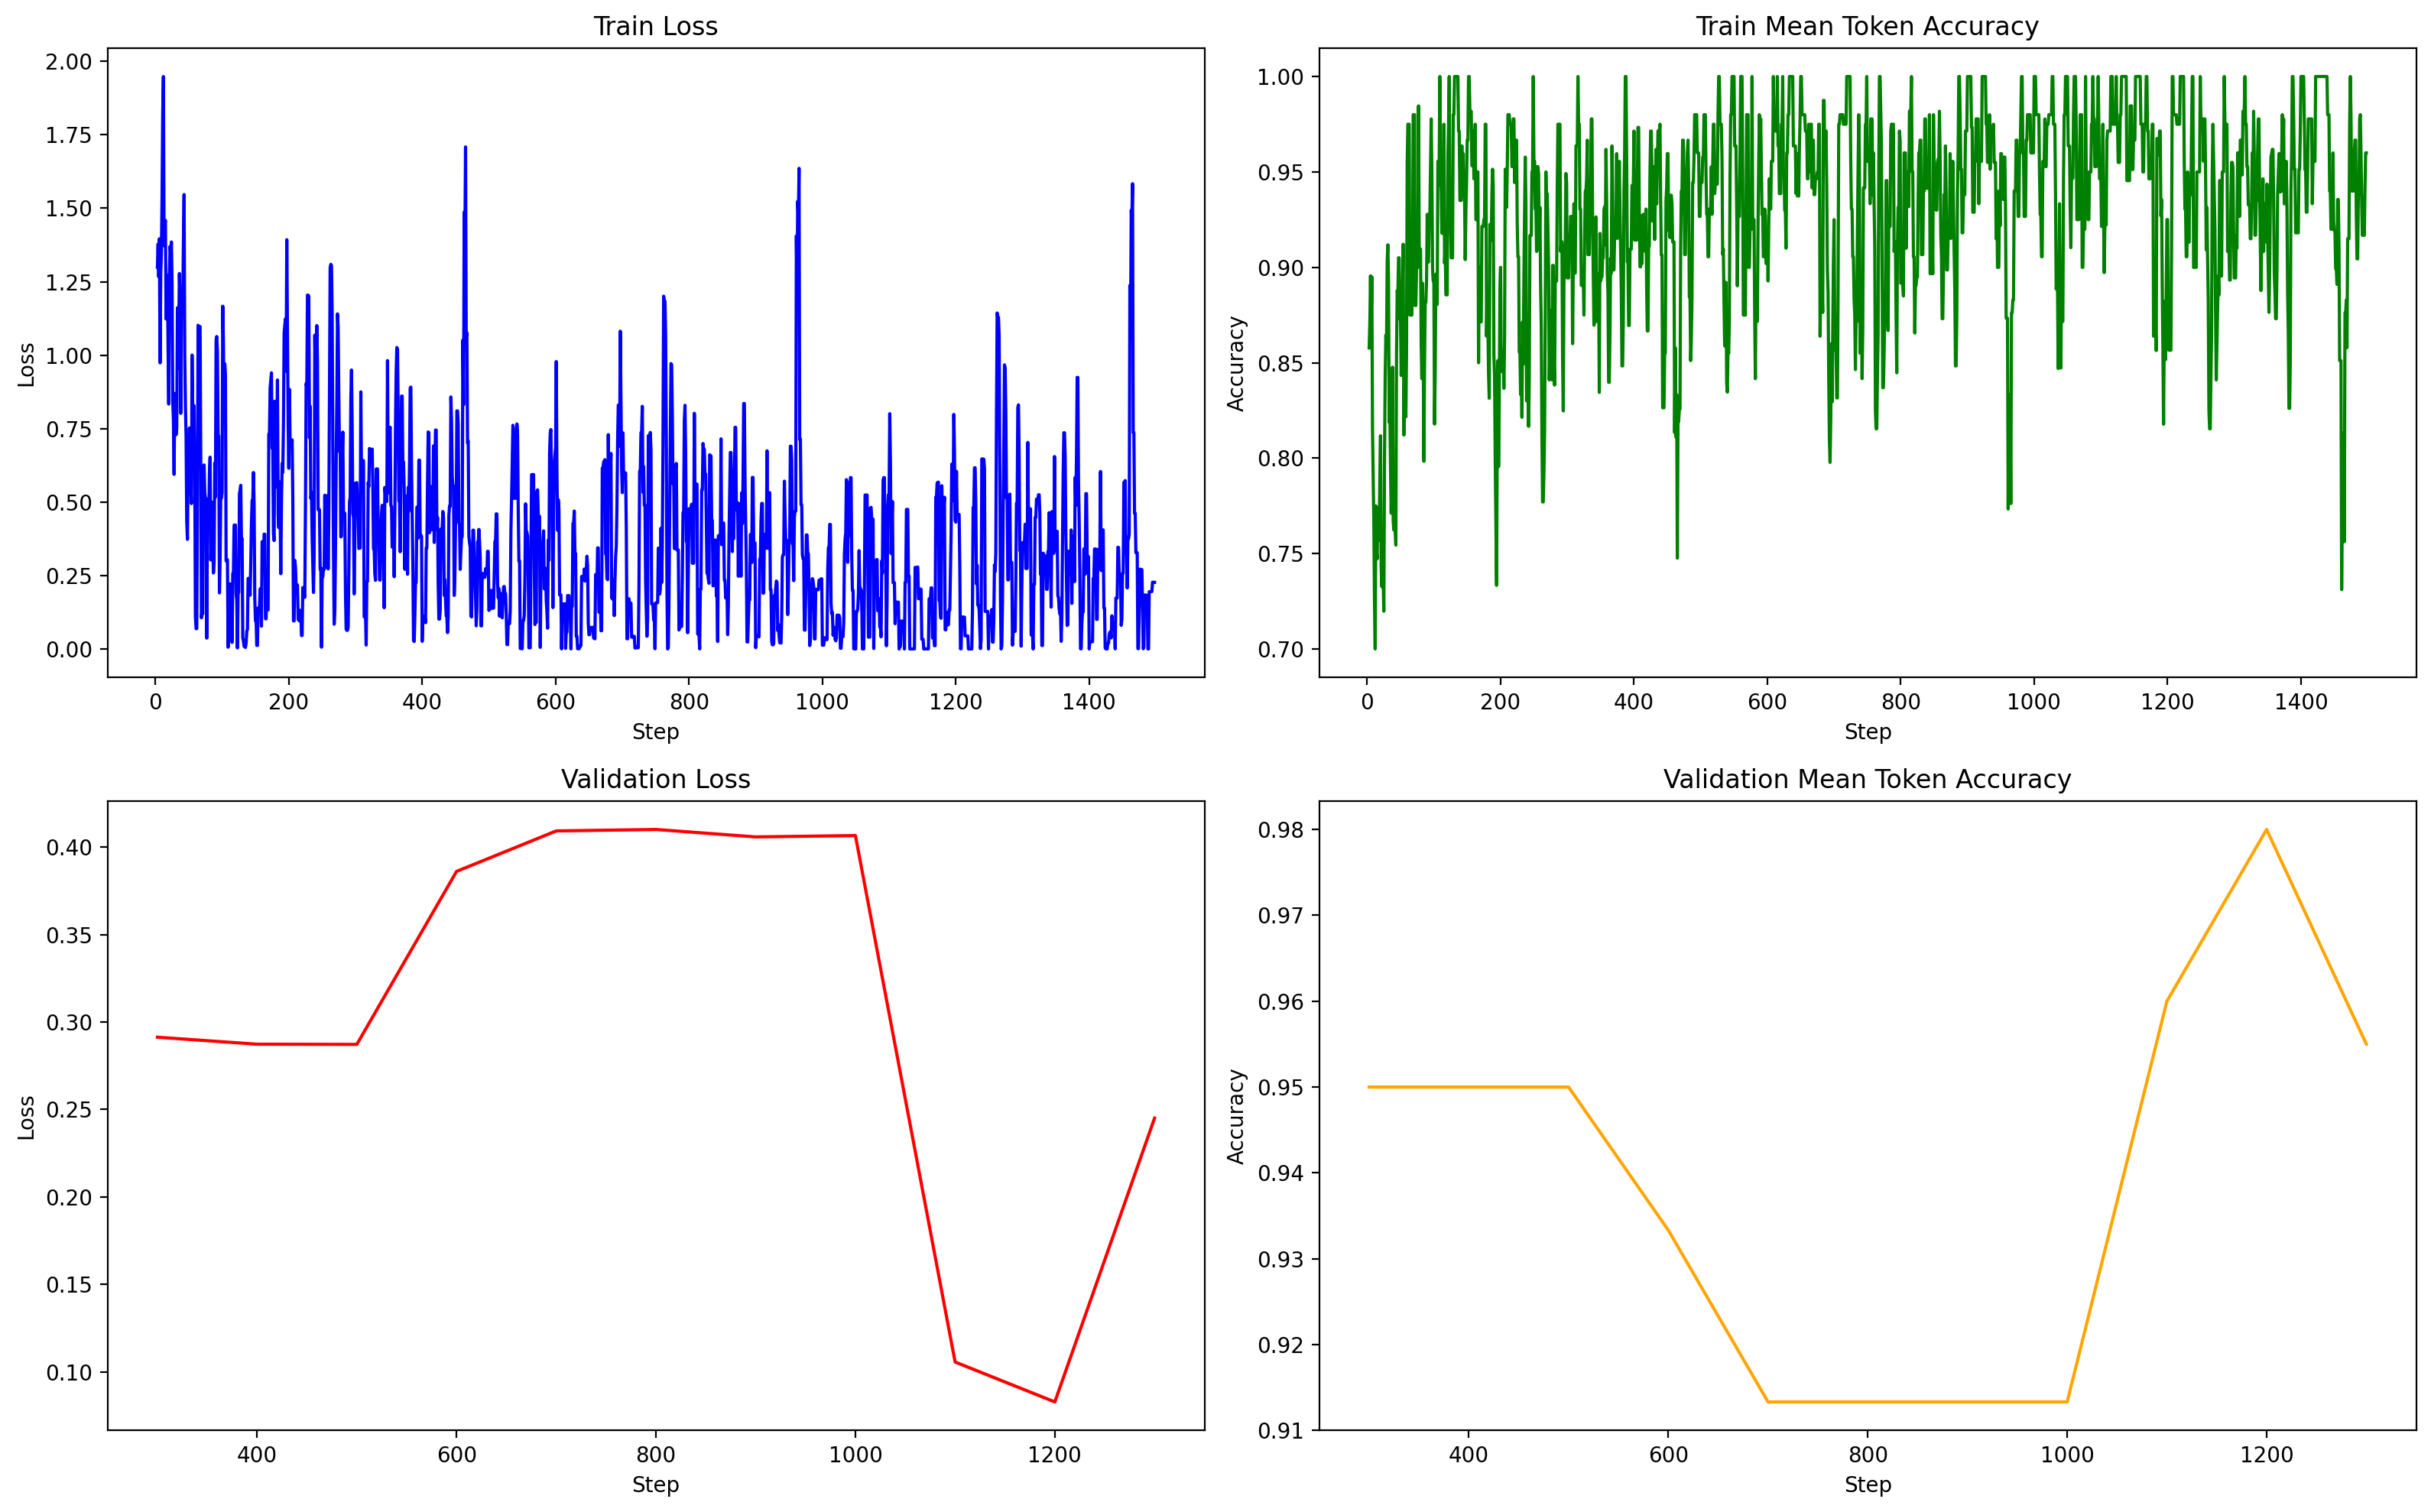

In [136]:
# Retrieve fine-tuning metrics from result file
result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()
data_io = StringIO(results_content)
results_df = pd.read_csv(data_io)
show_ft_metrics(results_df)

Take a look at this table for an interpretation of above diagrams:  

| Metric                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `step`                            | The number of the training step. A training step represents a single pass, forward and backward, on a batch of training data.                                                           |
| `train_loss`, `validation_loss` | The loss for the training / validation batch |
| `train_mean_token_accuracy`       | The percentage of tokens in the training batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |
| `validation_mean_token_accuracy`  | The percentage of tokens in the validation batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |

## 5 Deploy fine-tuned model
> __Note__  
> Only one deployment is permitted for a customized model. An error occurs if you select an already-deployed customized model.  

The code below shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

In [137]:
my_models = client.models.list().to_dict()
models_df = date_sorted_df(my_models['data'])
cols = ['status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model']
print(f'Models of Azure OpenAI resource {bold_start}{resource_name}{bold_end}:')
display(models_df[cols].head())

Models of Azure OpenAI resource azureopenai-sweden-sr:


,status,capabilities,lifecycle_status,id,created_at,model
79,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,2025-01-20 08:03:24,gpt-4o-2024-08-06
78,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,2025-01-20 08:03:24,gpt-4o-2024-08-06
77,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,2025-01-20 08:03:24,gpt-4o-2024-08-06
76,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,2025-01-17 16:39:12,gpt-4o-2024-08-06
74,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,2025-01-17 16:39:12,gpt-4o-2024-08-06


In [138]:
models_df

,id,object,status,capabilities,lifecycle_status,deprecation,created_at,model,fine_tune
79,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-20 08:03:24,gpt-4o-2024-08-06,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
78,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-20 08:03:24,gpt-4o-2024-08-06,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
77,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-20 08:03:24,gpt-4o-2024-08-06,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3
76,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-17 16:39:12,gpt-4o-2024-08-06,ftjob-c13effafe9e2421cb43f01426276c0ca
74,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-17 16:39:12,gpt-4o-2024-08-06,ftjob-c13effafe9e2421cb43f01426276c0ca
...,...,...,...,...,...,...,...,...,...
36,code-search-ada-text-001,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1718323200},2022-05-20 00:00:00,NaN,NaN
39,babbage,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
31,ada,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
50,davinci,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN


In [148]:
fine_tuned_model = models_df['id'].values[0].split(':')[0]
fine_tuned_model

'gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f0fb80d3-vqa-gpt4o'

In [149]:
aoai_deployment_name = project_name  # AOAI deployment name. Use as model parameter for inferencing

credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2023-05-01"}

deploy_headers = {
    'Authorization': 'Bearer {}'.format(token),
    'Content-Type': 'application/json'
}

deploy_data = {
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model,
            "version": "1"
        }
    }
}

deploy_data = json.dumps(deploy_data)

request_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}"

start = time.time()
print("Creating a new deployment ...\n")
req = requests.put(request_url,
                   params=deploy_params,
                   headers=deploy_headers,
                   data=deploy_data)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Done in {minutes:.0f} minutes and {seconds:.0f} seconds")

Creating a new deployment ...

Done in 0 minutes and 14 seconds


### Deployed model is in the deployment section of Azure AI Foundry

<img src="capture5.jpg">

### FT model deployment information

In [150]:
print(req)

<Response [201]>


In [151]:
print(req.reason)

Created


In [154]:
response_json = req.json()
print(json.dumps(response_json, indent=4))

{
    "id": "/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureopenai-suede-rg/providers/Microsoft.CognitiveServices/accounts/azureopenai-sweden-sr/deployments/vqa-gpt4o",
    "type": "Microsoft.CognitiveServices/accounts/deployments",
    "name": "vqa-gpt4o",
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": "gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f0fb80d3-vqa-gpt4o",
            "version": "1"
        },
        "versionUpgradeOption": "NoAutoUpgrade",
        "capabilities": {
            "area": "EUR",
            "chatCompletion": "true",
            "jsonSchemaResponse": "true",
            "maxContextToken": "128000",
            "maxOutputToken": "16384"
        },
        "provisioningState": "Creating"
    },
    "systemData": {
        "createdBy": "Serge.Retkowsky@microsoft.com",
        "createdByType": "User",
        "createdAt": "202

> Wait until the model is deployed

### Model deployment is SUCCEEDED

<img src="capture6.jpg">

## 6 Evaluate default versus fine-tuned model

In [155]:
ds_test

,question,answer,image
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
95,Who has hit the most home runs in Kansas City ...,George Brett,<PIL.PngImagePlugin.PngImageFile image mode=RG...
96,What's the number of the highest point?,83.29,<PIL.PngImagePlugin.PngImageFile image mode=RG...
97,What was the value of the commercial property ...,883,<PIL.PngImagePlugin.PngImageFile image mode=RG...
98,"In the first quarter of 2021, what percentage ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...


### Test Inference

'Which party is least likely to approve NSA surveillance?'

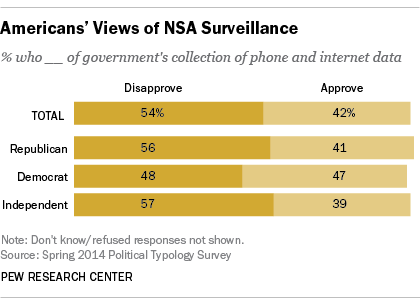

'Independent'

In [158]:
idx = 0

question = ds_test.iloc[idx]['question']
img = ds_test.iloc[idx]['image']
answer = ds_test.iloc[idx]['answer']

display(question)
display(img)
display(answer)

In [162]:
@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def query_image(image, question, deployment='gpt-4o'):
    """
    Queries an image-based question to a specified model deployment and returns the response.

    Parameters:
    image (PIL.Image.Image): The image to be encoded and queried.
    question (str): The question related to the image.
    deployment (str, optional): The model deployment to use for querying (default is 'gpt-4o').

    Returns:
    str: The response content from the model.
    """
    encoded_image_url = f"data:image/jpeg;base64,{encode_image(image, quality=50)}"

    response = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                {"type": "text", "text": question},
                {"type": "image_url", "image_url": {"url": encoded_image_url}}
            ]}
        ],
        temperature=0,
    )

    return response.choices[0].message.content

In [167]:
print("Answer is:\n")
display(answer)

Answer is:



'Independent'

In [172]:
print(f"VQA using the baseline model {baseline_model}: {query_image(img, question, baseline_model)}")

VQA using the baseline model gpt-4o-2024-08-06: Independent


In [173]:
print(f"VQA using the fine-tuned model {project_name}: {query_image(img, question, project_name)}")

VQA using the fine-tuned model vqa-gpt4o: Independent


### Use the base model

In [171]:
# Process test dataset with baseline model
print("Baseline model:", baseline_model)
start = time.time()

ds_test['gpt-4o-base-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], baseline_model), axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Baseline model: gpt-4o-2024-08-06
Elapsed time = 9 minutes and 54.28 seconds


In [174]:
ds_test

,question,answer,image,gpt-4o-base-pred
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Independent
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...,252 million
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.08
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1.14%
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...,706 million U.S. dollars
...,...,...,...,...
95,Who has hit the most home runs in Kansas City ...,George Brett,<PIL.PngImagePlugin.PngImageFile image mode=RG...,George Brett
96,What's the number of the highest point?,83.29,<PIL.PngImagePlugin.PngImageFile image mode=RG...,83.29%
97,What was the value of the commercial property ...,883,<PIL.PngImagePlugin.PngImageFile image mode=RG...,883 billion GBP
98,"In the first quarter of 2021, what percentage ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...,30%


### Use the fine tuned model

In [175]:
# Process test dataset with fine-tuned model
print("Fine-tuned model:", project_name)
start = time.time()

ds_test['gpt-4o-ft-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], project_name), axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Fine-tuned model: vqa-gpt4o
Elapsed time = 2 minutes and 1.75 seconds


In [176]:
ds_test

,question,answer,image,gpt-4o-base-pred,gpt-4o-ft-pred
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Independent,Independent
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...,252 million,252
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.08,0.08
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1.14%,1.14
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...,706 million U.S. dollars,706
...,...,...,...,...,...
95,Who has hit the most home runs in Kansas City ...,George Brett,<PIL.PngImagePlugin.PngImageFile image mode=RG...,George Brett,George Brett
96,What's the number of the highest point?,83.29,<PIL.PngImagePlugin.PngImageFile image mode=RG...,83.29%,83.29
97,What was the value of the commercial property ...,883,<PIL.PngImagePlugin.PngImageFile image mode=RG...,883 billion GBP,883
98,"In the first quarter of 2021, what percentage ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...,30%,30


### Evaluation

In [177]:
EVAL_SYSTEM_PROMPT = """You evaluate the factual correctness of a predicted answer about a diagram with a ground truth answer. 
The predicted answer might be formulated in a different way. Your only concern is if the predicted answer is correct from a factual perspective.
You are provided with the original question, the ground truth answer and the predicted answer.
You respond with either CORRECT or INCORRECT"""


@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def evaluate(question,
             ground_truth_answer,
             predicted_answer,
             deployment=baseline_model):
    """
    Evaluates the predicted answer against the ground truth answer using a specified model deployment.

    Parameters:
    question (str): The original question posed.
    ground_truth_answer (str): The correct answer to the question.
    predicted_answer (str): The answer predicted by the model.
    deployment (str, optional): The model deployment to use for evaluation (default is baseline_model).

    Returns:
    str: The evaluation response from the model.
    """
    user_prompt = f"Original question: {question} \nGround truth answer: {ground_truth_answer}\nPredicted answer: {predicted_answer}"

    response = client.chat.completions.create(
        model=baseline_model,
        messages=[{
            "role": "system",
            "content": EVAL_SYSTEM_PROMPT
        }, {
            "role": "user",
            "content": user_prompt
        }],
        temperature=0,
    )

    return response.choices[0].message.content

In [178]:
# Quick evaluation of the function when we have similar content
print(evaluate('what is the diagram title?', 'comparison of tax rates in EU', 'tax rates comparison across Europe'))

CORRECT


In [180]:
# Quick evaluation of the function when we have different content
print(evaluate('what is the diagram title?', '100 euros', '250 $'))

INCORRECT


In [181]:
# Validate prediction accuracy of baseline model
start = time.time()

ds_test['gpt-4o-base-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-base-pred'], baseline_model), axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Elapsed time = 8 minutes and 50.40 seconds


In [182]:
# Validate prediction accuracy of fine-tuned model
start = time.time()

ds_test['gpt-4o-ft-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-ft-pred'], baseline_model), axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Elapsed time = 10 minutes and 21.06 seconds


In [183]:
ds_test

,question,answer,image,gpt-4o-base-pred,gpt-4o-ft-pred,gpt-4o-base-eval,gpt-4o-ft-eval
0,Which party is least likely to approve NSA sur...,Independent,<PIL.PngImagePlugin.PngImageFile image mode=RG...,Independent,Independent,CORRECT,CORRECT
1,What is the estimated number of passengers tra...,252,<PIL.PngImagePlugin.PngImageFile image mode=RG...,252 million,252,CORRECT,CORRECT
2,What the difference in value between Papua New...,0.08,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0.08,0.08,CORRECT,CORRECT
3,What percentage of North America's GDP did B2C...,1.14,<PIL.PngImagePlugin.PngImageFile image mode=RG...,1.14%,1.14,CORRECT,CORRECT
4,How much revenue did Pinterest generate in the...,706,<PIL.PngImagePlugin.PngImageFile image mode=RG...,706 million U.S. dollars,706,CORRECT,CORRECT
...,...,...,...,...,...,...,...
95,Who has hit the most home runs in Kansas City ...,George Brett,<PIL.PngImagePlugin.PngImageFile image mode=RG...,George Brett,George Brett,CORRECT,CORRECT
96,What's the number of the highest point?,83.29,<PIL.PngImagePlugin.PngImageFile image mode=RG...,83.29%,83.29,CORRECT,CORRECT
97,What was the value of the commercial property ...,883,<PIL.PngImagePlugin.PngImageFile image mode=RG...,883 billion GBP,883,CORRECT,CORRECT
98,"In the first quarter of 2021, what percentage ...",30,<PIL.PngImagePlugin.PngImageFile image mode=RG...,30%,30,CORRECT,CORRECT


<Axes: xlabel='gpt-4o-base-eval'>

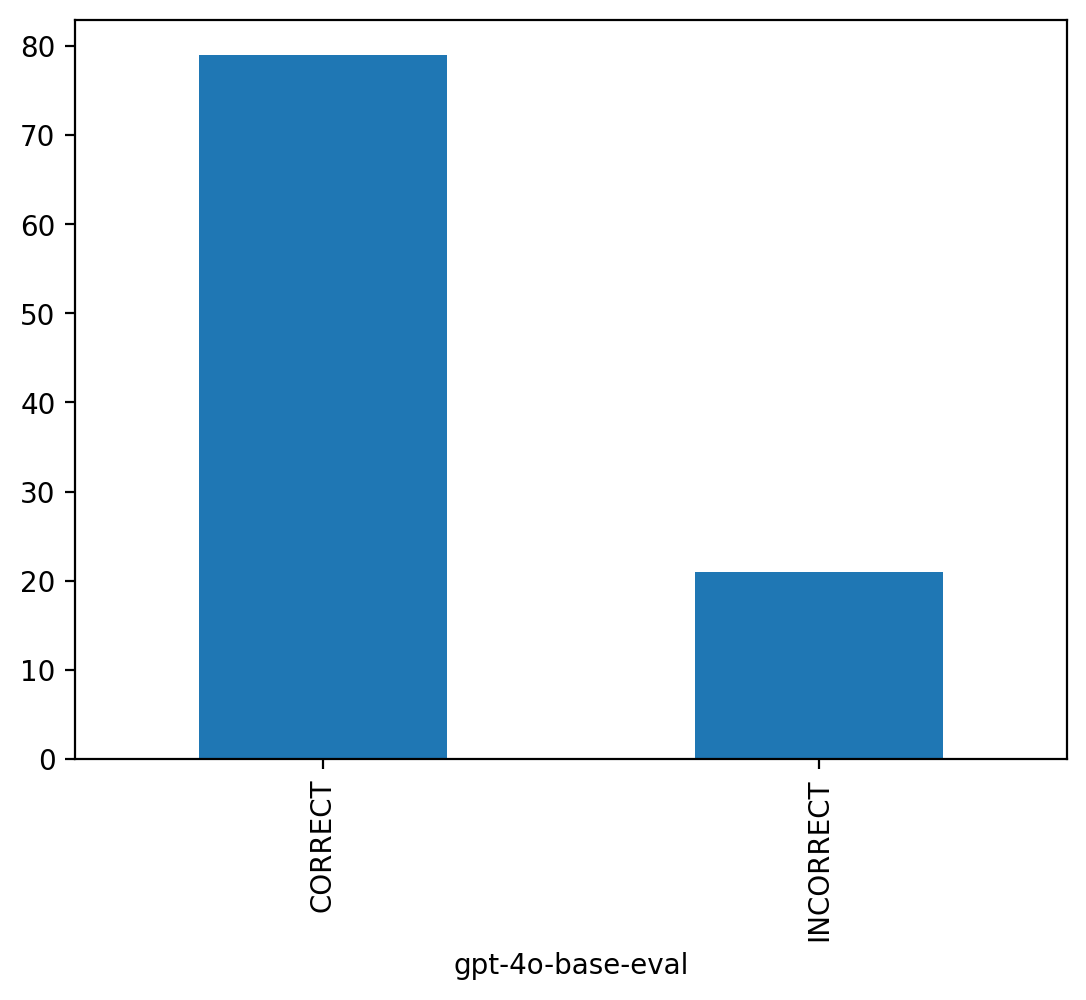

In [190]:
ds_test['gpt-4o-base-eval'].value_counts(sort=True).plot.bar()

<Axes: xlabel='gpt-4o-ft-eval'>

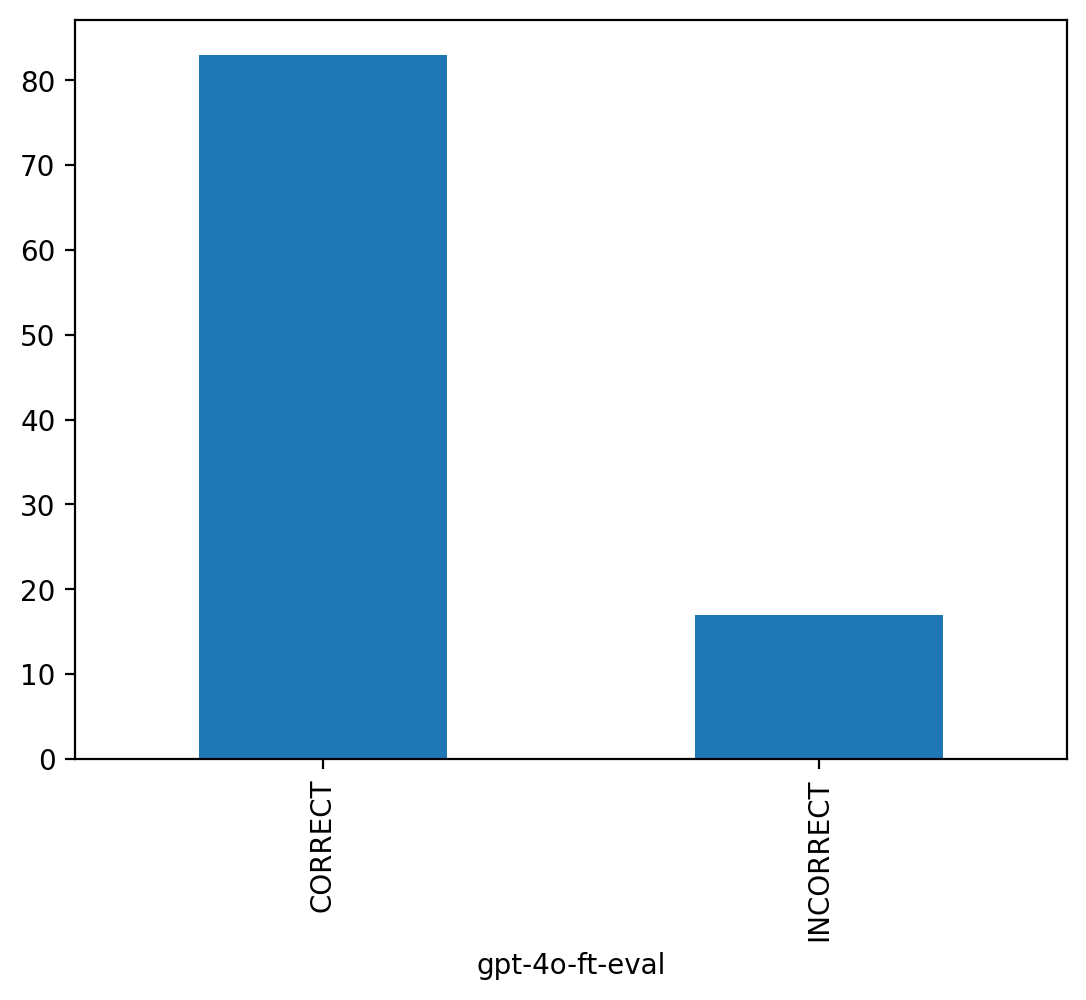

In [191]:
ds_test['gpt-4o-ft-eval'].value_counts(sort=True).plot.bar()

In [186]:
ds_test['gpt-4o-base-eval'].value_counts(sort=True, normalize=True)

gpt-4o-base-eval
CORRECT      0.79
INCORRECT    0.21
Name: proportion, dtype: float64

In [188]:
ds_test['gpt-4o-ft-eval'].value_counts(sort=True, normalize=True)

gpt-4o-ft-eval
CORRECT      0.83
INCORRECT    0.17
Name: proportion, dtype: float64

<img src="capture7.jpg">

### Exports

In [192]:
# Export to CSV and excel files
output_file = f"vqa_evaluation_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
output_csv_file = f"{output_file}.csv"
output_excel_file = f"{output_file}.xlsx"

In [193]:
# Export to CSV
ds_test.to_csv(output_csv_file, index=False)
!ls $output_csv_file -lh

-rwxrwxrwx 1 root root 19K Jan 20 13:36 vqa_evaluation_2025-01-20_13-36-55.csv


In [194]:
# Export to Excel
ds_test.to_excel(output_excel_file)
!ls $output_excel_file -lh

-rwxrwxrwx 1 root root 13K Jan 20 13:36 vqa_evaluation_2025-01-20_13-36-55.xlsx


### Evaluation graph

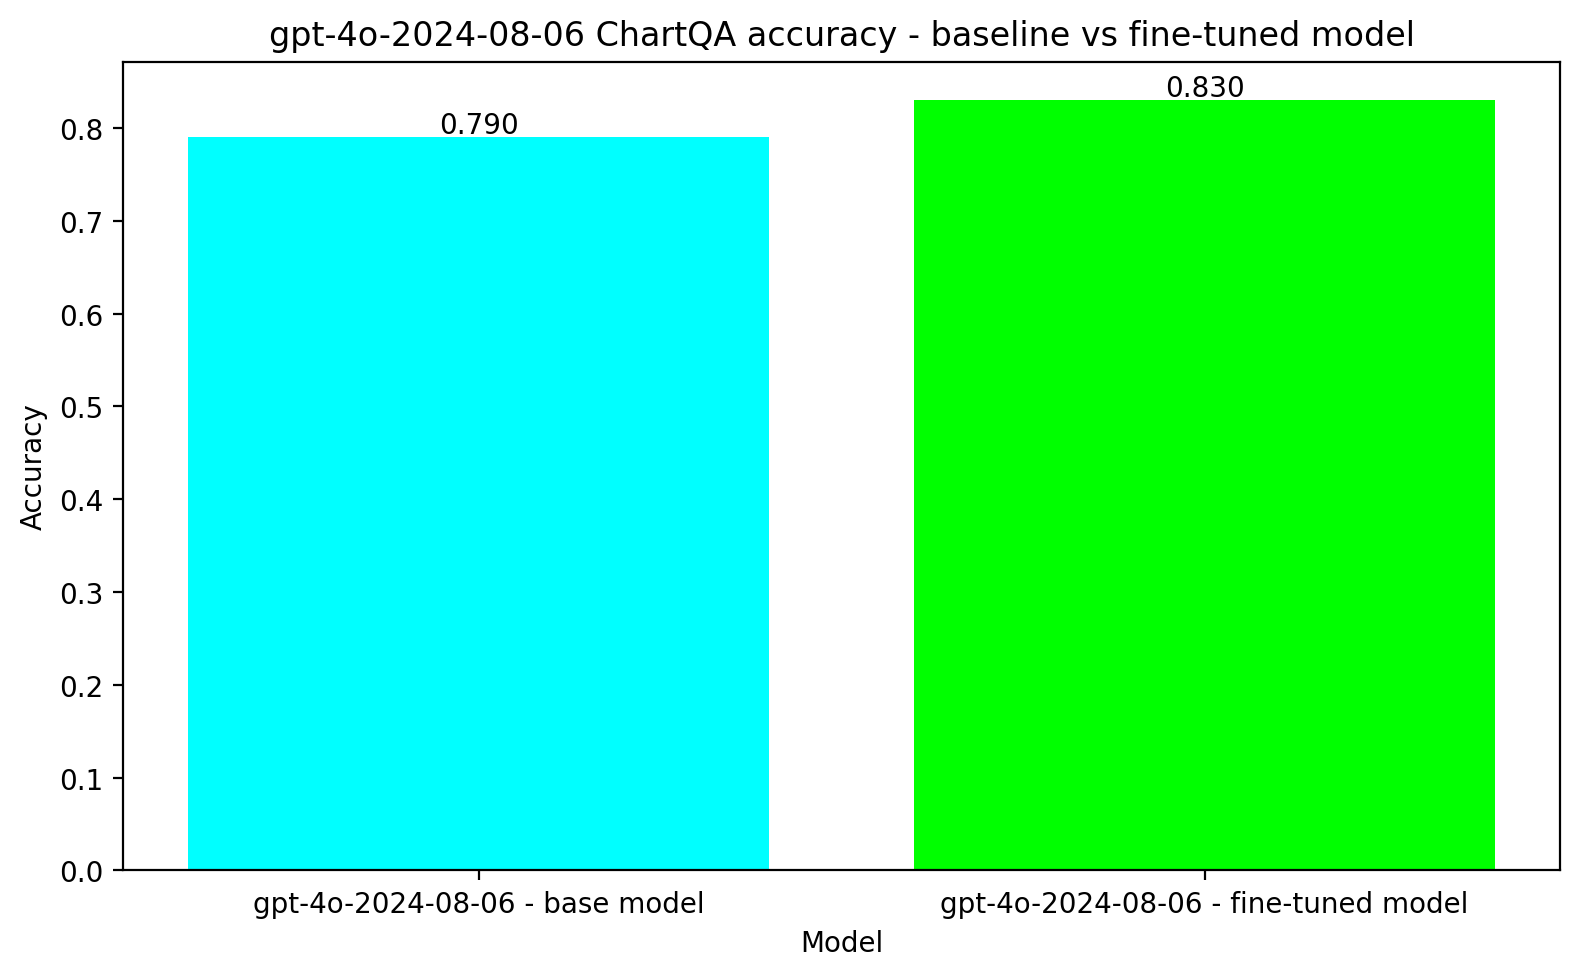

In [196]:
base_correct_count = ds_test['gpt-4o-base-eval'].value_counts().get("CORRECT", 0)
base_eval_observations = ds_test.shape[0]
ft_correct_count = ds_test['gpt-4o-ft-eval'].value_counts().get("CORRECT", 0)
ft_eval_observations = ds_test.shape[0]

chart_data = {
    'title':
    'gpt-4o-2024-08-06 ChartQA accuracy - baseline vs fine-tuned model',
    'baseline': 'gpt-4o-2024-08-06 - base model',
    'fine-tuned': 'gpt-4o-2024-08-06 - fine-tuned model',
    'baseline accuracy': base_correct_count / base_eval_observations,
    'fine-tuned accuracy': ft_correct_count / ft_eval_observations,
}

models = [chart_data['baseline'], chart_data['fine-tuned']]
accuracies = [chart_data['baseline accuracy'], chart_data['fine-tuned accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['cyan', 'lime'])
plt.title(chart_data['title'])
plt.ylabel('Accuracy')
plt.xlabel('Model')
for idx, acc in enumerate(accuracies):
    plt.text(idx, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig(f"{output_file}.png")
plt.show()

> Small increase of quality. You can add more images for the training part.